# Generate summary figures for talk
This notebook generates relevant figures summarizing library neutralization analysis thus far. 

The following figures are generated (in order):
* Neutralization curves for AUSAB-07 neutralization of HK19 and H6, including data from all runs.
* Neutralization curve for AUSAB-07 against wt-HK19, with relevant serum dilutions marked on the plot. Note that these concentrations have increased since the initial runs.
* Fraction of counts from neutralization standard. Reduced to just no-antibody controls and serum selections from 4-19-22, for both libA and libB selections.

Output figures are saved in `scratch_figs/`. 

In [1]:
import os
import pickle

import altair as alt

import pandas as pd

import yaml

import neutcurve
from neutcurve.colorschemes import CBMARKERS, CBPALETTE
from matplotlib import pyplot as plt

import matplotlib.transforms
import warnings 
warnings.filterwarnings("ignore")

import Bio.SeqIO

import dms_variants.codonvarianttable
import dms_variants.utils

In [2]:
# allow more rows for Altair
_ = alt.data_transformers.disable_max_rows()

In [3]:
# change working directory to top of repo
os.chdir('../../')

In [4]:
with open('config.yaml') as f:
    config = yaml.safe_load(f)

### AUSAB-07 neut curves
Get a plot of AUSAB-07 neutralization against HK/2019 and H6 standard, including data from all runs. Then, generate a single neut curve showing HK/2019 neutralization, and plot the serum dilutions used for selections on 2-24-22.

Data pulled from `experiments/neut_assays/neut_data/`

In [5]:
ser07_run2 = (
    pd.read_excel('experiments/neut_assays/neut_data/2022-01-19_HK19_redone_H6R235M_AG_AUSAB_tidy.xlsx')
    .query('serum == "07-AUSAB"')
)

ser07_run2['virus'] = ser07_run2.apply(lambda x: 'HK19_WT_run2' if x['virus'] == 'HK19_WT' else x['virus'], axis=1)

ser07_run1 = (
    pd.read_excel('experiments/neut_assays/neut_data/2022-01-14-HK19_AlexGreninger_AUSAB01-16_tidy.xlsx')
    .query('serum == "07-AUSAB"')
    .query('concentration != 0.000390625') # drop this, measured in second run already
)

ser07_run1['virus'] = ser07_run1.apply(lambda x: 'HK19_WT_run1' if x['virus'] == 'HK19_WT' else x['virus'], axis=1)


ser07 = ser07_run1.append(ser07_run2)

ser07.head()

,serum,virus,replicate,concentration,fraction infectivity
96,07-AUSAB,HK19_WT_run1,1,0.050000,0.036830
97,07-AUSAB,HK19_WT_run1,1,0.025000,0.046258
98,07-AUSAB,HK19_WT_run1,1,0.012500,0.034572
99,07-AUSAB,HK19_WT_run1,1,0.006250,0.042413
100,07-AUSAB,HK19_WT_run1,1,0.003125,0.036047


In [6]:
fits07 = neutcurve.CurveFits(ser07)

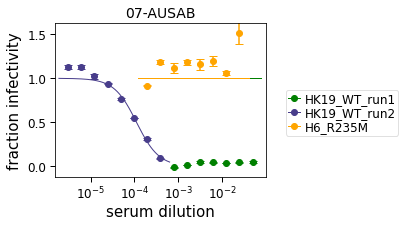

In [7]:
fig, axes = fits07.plotSera(
    xlabel='serum dilution',
    virus_to_color_marker={
        'HK19_WT_run1': ('green', 'o'),
        'HK19_WT_run2': ('DarkSlateBlue', 'o'),
        'H6_R235M': ('orange', 'o')}
)

import matplotlib.transforms

# prevent legend from getting cut off
bbox = matplotlib.transforms.Bbox([[0, 0], [5.7, 3.3]])
plt.savefig('scratch_notebooks/220516_summary_figures/scratch_figs/ser07_neut_curve_all.pdf', bbox_inches=bbox)

Now remove the H6 data, condense to a single curve, and add lines at serum dilutions

In [8]:
ser07_hk19 = ser07.loc[(ser07['virus'] == 'HK19_WT_run1') | (ser07['virus'] == 'HK19_WT_run2')]

# remove run labels
ser07_hk19['virus'] = 'HK19_WT'
fits07_hk19 = neutcurve.CurveFits(ser07_hk19)

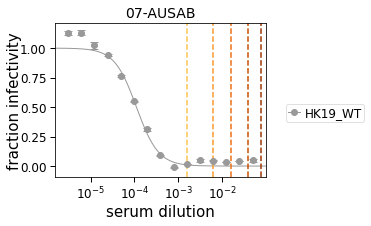

In [9]:
fig, axes =fits07_hk19.plotSera(
                xlabel='serum dilution',
                virus_to_color_marker={
                    'HK19_WT': ('#999999', 'o')}, 
    
                # assign sequential color scheme
#                 vlines={'07-AUSAB': [{'x': 0.000158, 'color': '#FEC44F'}, {'x': 0.000395, 'color':'#FB9A29'}, 
#                                      {'x': 0.00158, 'color': '#EC7014'}, {'x': 0.00632, 'color':'#CC4C02'}, 
#                                      {'x': 0.0158, 'color':'#993404'}],
                vlines={'07-AUSAB': [{'x': 0.00158, 'color': '#FEC44F'}, {'x': 0.00632, 'color':'#FB9A29'}, 
                             {'x': 0.0158, 'color': '#EC7014'}, {'x': 0.0395, 'color':'#CC4C02'}, 
                             {'x': 0.079, 'color':'#993404'}],
                        },
                )

bbox = matplotlib.transforms.Bbox([[0, 0], [5.5, 3.3]])

plt.savefig('scratch_notebooks/220516_summary_figures/scratch_figs/ser07_neut_curve_ic_higher.pdf', bbox_inches = bbox)

In [11]:
# for reference, get IC values for each dilution measured
dilutions = [0.000158, 0.000395, 0.00158, 0.00632, 0.0158, 0.0395, 0.079]

for dilution in dilutions:
    ic = 100 * (1 - (fits07_hk19.getCurve(serum='07-AUSAB', virus='HK19_WT', replicate='average').fracinfectivity(dilution)))
    ic = str(ic)[0:8]
    print(f'{dilution}: IC{ic}')

0.000158: IC64.84704
0.000395: IC89.98258
0.00158: IC98.99514
0.00632: IC99.90753
0.0158: IC99.98099
0.0395: IC99.99609
0.079: IC99.99882


### Neutralization standard fractions
Edit code from `notebooks/analyze_barcode_counts.ipynb` to plot fraction neut standard at each serum dilution. Simplify sample names and use consistent color scheme from above.

First, load in barcode counts data and define neut standards

In [10]:
barcode_runs = pd.read_csv(config["barcode_runs"])

library_sample_list = barcode_runs["library_sample"].tolist()

In [11]:
counts = (
    pd.concat([
        pd.read_csv(os.path.join(subdir, library_sample + ".csv")).assign(valid=valid)
        for library_sample in library_sample_list
        for (subdir, valid) in [
            (config["barcode_counts_dir"], True),
            (config["barcode_counts_invalid_dir"], False),
        ]
    ])
)

In [12]:
neut_standard_barcodes = pd.read_csv(config["neut_standard_barcodes"])["barcode"].tolist()

In [24]:
# calculate fraction neut standard for all samples
frac_neut_standard = (
    counts
    .query("valid")
    .assign(is_neut_standard=lambda x: x["barcode"].isin(neut_standard_barcodes))
    .groupby(["library", "sample", "is_neut_standard"], as_index=False)
    .aggregate(counts=pd.NamedAgg("count", "sum"))
    .assign(
        total_counts=lambda x: x.groupby(["library", "sample"])["counts"].transform("sum"),
        frac=lambda x: x["counts"] / x["total_counts"],
    )
    .query("is_neut_standard")
    .merge(barcode_runs, validate="one_to_one")
    .drop(columns=["fastq_R1", "notes", "antibody_concentration", "counts", "is_neut_standard"])
)

# # reduce to just the samples of interest, simplifying names at the same time.
# short_names = {
#     '220224_1_antibody_AUSAB-07_0.000158_1_rt1': 'serum-IC65_1_RT-1',
#     '220224_1_antibody_AUSAB-07_0.000158_1_rt2': 'serum-IC65_1_RT-2',
#     '220224_1_antibody_AUSAB-07_0.000158_2': 'serum-IC65_2',
#     '220224_1_antibody_AUSAB-07_0.000395_1': 'serum-IC90_1',
#     '220224_1_antibody_AUSAB-07_0.000395_2': 'serum-IC90_2',
#     '220224_1_antibody_AUSAB-07_0.00158_1': 'serum-IC99_1',
#     '220224_1_antibody_AUSAB-07_0.00158_2': 'serum-IC99_2',
#     '220224_1_antibody_AUSAB-07_0.00632_1': 'serum-IC99.90_1',
#     '220224_1_antibody_AUSAB-07_0.00632_2': 'serum-IC99.90_2',
#     '220224_1_antibody_AUSAB-07_0.0158_1': 'serum-IC99.99_1',
#     '220224_1_antibody_AUSAB-07_0.0158_2_rt1': 'serum-IC99.99_2_RT-1',
#     '220224_1_antibody_AUSAB-07_0.0158_2_rt2': 'serum-IC99.99_2_RT-2',
#     '220224_1_no-antibody_control_670ng_1': 'no-Ab_1',
#     '220224_1_no-antibody_control_670ng_2': 'no-Ab_2'
# }

# names for 220516 analysis
short_names = {
#     'libA_220303_1_plasmid': 'libA_plasmid',
    'libA_220419_1_antibody_AUSAB-07_0.00158_1': 'libA_serum-0.00158_1',
    'libA_220419_1_antibody_AUSAB-07_0.00158_2': 'libA_serum-0.00158_2',
    'libA_220419_1_antibody_AUSAB-07_0.00632_1': 'libA_serum-0.00632',
    'libA_220419_1_antibody_AUSAB-07_0.0158_1': 'libA_serum-0.0158',
    'libA_220419_1_antibody_AUSAB-07_0.0395_1': 'libA_serum-0.0395',
    'libA_220419_1_antibody_AUSAB-07_0.079_1': 'libA_serum-0.079_1',
    'libA_220419_1_antibody_AUSAB-07_0.079_2': 'libA_serum-0.079_2',
    'libA_220419_1_no-antibody_control_1': 'libA_no-Ab-control_1',
    'libA_220419_1_no-antibody_control_2': 'libA_no-Ab-control_2',
#     'libB_220303_1_plasmid': 'libB_plasmid',
    'libB_220419_1_antibody_AUSAB-07_0.00158_1': 'libB_serum-0.00158_1',
    'libB_220419_1_antibody_AUSAB-07_0.00158_2': 'libB_serum-0.00158_2',
    'libB_220419_1_antibody_AUSAB-07_0.00632_1': 'libB_serum-0.00632',
    'libB_220419_1_antibody_AUSAB-07_0.0158_1': 'libB_serum-0.0158',
    'libB_220419_1_antibody_AUSAB-07_0.0395_1': 'libB_serum-0.0395',
    'libB_220419_1_antibody_AUSAB-07_0.079_1': 'libB_serum-0.079_1',
    'libB_220419_1_antibody_AUSAB-07_0.079_2': 'libB_serum-0.079_2',
    'libB_220419_1_no-antibody_control_1': 'libB_no-Ab-control_1',
    'libB_220419_1_no-antibody_control_2': 'libB_no-Ab-control_2',
}

frac_neut_standard['library_sample'] = frac_neut_standard['library_sample'].map(short_names)
frac_neut_standard = frac_neut_standard.dropna(subset=['library_sample'])

# add column defining serum dilution (or no Ab samples)
frac_neut_standard['condition'] = frac_neut_standard['library_sample'].str.split('_').str[1]

frac_neut_standard.head()

,library,sample,total_counts,frac,date,virus_batch,sample_type,antibody,replicate,library_sample,condition
52,libA,220419_1_antibody_AUSAB-07_0.00158_1,4881317,0.000522,220419,1,antibody,AUSAB-07,1,libA_serum-0.00158_1,serum-0.00158
53,libA,220419_1_antibody_AUSAB-07_0.00158_2,5805439,0.000529,220419,1,antibody,AUSAB-07,2,libA_serum-0.00158_2,serum-0.00158
54,libA,220419_1_antibody_AUSAB-07_0.00632_1,4435701,0.000935,220419,1,antibody,AUSAB-07,1,libA_serum-0.00632,serum-0.00632
55,libA,220419_1_antibody_AUSAB-07_0.0158_1,3734212,0.002267,220419,1,antibody,AUSAB-07,1,libA_serum-0.0158,serum-0.0158
56,libA,220419_1_antibody_AUSAB-07_0.0395_1,3422408,0.020749,220419,1,antibody,AUSAB-07,1,libA_serum-0.0395,serum-0.0395


In [33]:
# tidy for plotting
frac_neut_tidy = (frac_neut_standard
                  .pivot(index=['condition','library'], columns='replicate', values='frac')
                  .reset_index()
                  .rename_axis(None, axis=1)
                  .melt(id_vars=['condition', 'library'], var_name='replicate', value_name='frac')
                  .dropna()
                 )

# add same color map from neut curve
color_map = {'serum-0.00158': '#FEC44F', 'serum-0.00632': '#FB9A29', 'serum-0.0158': '#EC7014', 
             'serum-0.0395': '#CC4C02', 'serum-0.079': '#993404', 'no-Ab-control': '#999999'
            }


#                 vlines={'07-AUSAB': [{'x': 0.00158, 'color': '#FEC44F'}, {'x': 0.00632, 'color':'#FB9A29'}, 
#                              {'x': 0.0158, 'color': '#EC7014'}, {'x': 0.0395, 'color':'#CC4C02'}, 
#                              {'x': 0.079, 'color':'#993404'}],
#                         },

frac_neut_tidy['color'] = frac_neut_tidy['condition'].map(color_map)

frac_neut_tidy

,condition,library,replicate,frac,color
0,no-Ab-control,libA,1,0.000475,#999999
1,no-Ab-control,libB,1,0.000347,#999999
2,serum-0.00158,libA,1,0.000522,#FEC44F
3,serum-0.00158,libB,1,0.000385,#FEC44F
4,serum-0.00632,libA,1,0.000935,#FB9A29
5,serum-0.00632,libB,1,0.000645,#FB9A29
6,serum-0.0158,libA,1,0.002267,#EC7014
7,serum-0.0158,libB,1,0.001772,#EC7014
8,serum-0.0395,libA,1,0.020749,#CC4C02
9,serum-0.0395,libB,1,0.018620,#CC4C02


In [41]:
frac_neut_standard_chart = (
    alt.Chart(frac_neut_tidy)
    .encode(
        x=alt.X(
            "frac",
            title="fraction counts from neutralization standard",
            scale=alt.Scale(type="symlog", constant=0.02, domainMax=1),
        ),
        y=alt.Y("condition", title=None),
        color=alt.Color('color', scale = None)
    )
    .mark_point(filled=True, size=50, opacity=0.7)
    .facet(facet=alt.Facet('library', title=None), columns=1)
#     .properties(width=245, height=alt.Step(15))
#     .configure_axis(labelLimit=500)
)


# site_freqs_chart = (
#     alt.layer(
#         site_freqs_base.mark_point(filled=True, size=25),
#         site_freqs_base.mark_line(size=0.4),
#         data=site_freqs,
#     )
#     .add_selection(zoom_brush)
#     .facet(facet=alt.Facet("library_sample", title=None), columns=2)
#     .transform_filter(zoom_brush)
# )

frac_neut_standard_chart.save('scratch_notebooks/220516_summary_figures/scratch_figs/220419_frac_neut_std.pdf')

frac_neut_standard_chart

alt.FacetChart(...)